In [1]:
import pandas as pd
import librosa as lib
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa as lib
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [282]:
import os

# def rename_files(root_dir):
#     root_dir = os.path.abspath(root_dir)
#     genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
#     for genre in genres:
#         genre_path = os.path.join(root_dir, genre)
#         list_files = os.listdir(genre_path)
#         for filename in list_files:
#             old_filepath = os.path.join(genre_path, filename)
#             new_filename = genre + "_" + filename.replace(".0", "_")
#             new_filepath = os.path.join(genre_path, new_filename)
#             os.rename(old_filepath, new_filepath)
#         print(f"Renamed {genre} files")

def rename_files(root_dir):
    root_dir = os.path.abspath(root_dir)
    for emotion in ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]:
        emotional_path = os.path.join(root_dir, str(emotion))
        list_emotions = os.listdir(emotional_path)
        for each_emotion in list_emotions:
            file_parts = each_emotion.split('.')
            piece = os.path.join(emotional_path, each_emotion)
            new_piece = os.path.join(emotional_path, emotion + str("_") + file_parts[1] + str(".") + file_parts[2])
            os.rename(piece, new_piece)
        
        print(f"Renamed {emotion} files")

In [283]:
rename_files('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original')

Renamed blues files
Renamed classical files
Renamed country files
Renamed disco files
Renamed hiphop files
Renamed jazz files
Renamed metal files
Renamed pop files
Renamed reggae files
Renamed rock files


In [2]:
def create_df(root_path):
    label = 0
    audio_name = []
    label_list = []
    for emotion in ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]:
        emotional_path = os.path.join(root_path, str(emotion))
        list_emotions = os.listdir(emotional_path)
        for each_emotion in list_emotions:
            piece = os.path.join(emotional_path, each_emotion)
            audio_name.append(piece)
            label_list.append(label)
        label += 1
    df = pd.DataFrame(columns = ['audio_name', 'emotion_label'])
    df["audio_name"] = audio_name
    df["emotion_label"] = label_list
    return df

In [3]:
audio_df = create_df('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original')

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\patel\AppData\Local\Temp\ipykernel_14384\726436136.py:1: SyntaxWarning: invalid escape sequence '\C'
  audio_df = create_df('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original')


In [4]:
audio_df.to_csv('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/metaFile.csv', index = False)

In [5]:
audio_df = pd.read_csv('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/metaFile.csv')

In [6]:
audio_df

,audio_name,emotion_label
0,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,0
1,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,0
2,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,0
3,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,0
4,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,0
...,...,...
994,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,9
995,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,9
996,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,9
997,D:\College\Semester 6\ML\Lab\Project-MoodDetec...,9


In [7]:
sample_1 = lib.load(audio_df['audio_name'][0])  # load the first audio file
x, y = sample_1 # x is the audio data, y is the sample rate
x.shape 

(661794,)

In [8]:
#number of samples per time step in spectrogram 
hl = 100
#height of image
hi = 224
#width of image
wi = 224

In [9]:
window = x[0:wi*hl] # get the first 224*256 samples

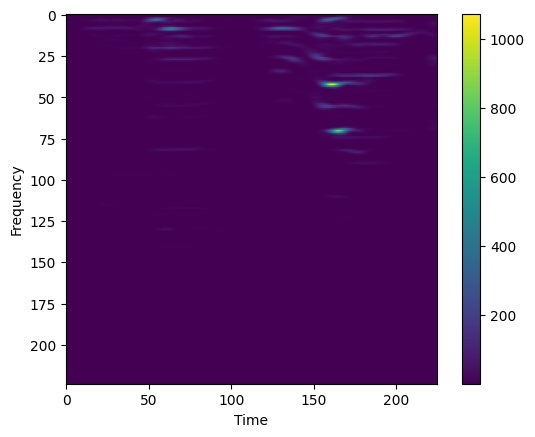

In [10]:
S = lib.feature.melspectrogram(y = window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl) # create a mel spectrogram

plt.imshow(S)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.colorbar()
plt.show()

In [11]:
S_db = lib.power_to_db(S, ref = np.max) # convert to decibels to make it easier to see

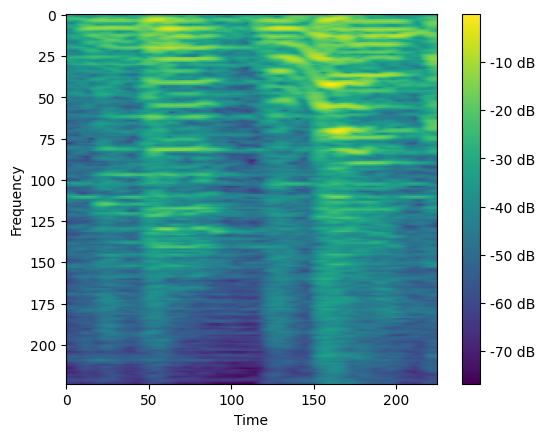

In [12]:
plt.imshow(S_db) # plot the spectrogram
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format='%+2.0f dB')

# Dataset Class and Function

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler

## Sets up a pipeline for loading and preprocessing audio data for machine learning tasks using PyTorch

In [14]:
import cv2
class Data_Prepare(Dataset): # create a dataset class
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform # transform object
        self.hl = 512
        self.hi = 224
        self.wi = 224
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index): # get the data
        if torch.is_tensor(index):
            index = index.tolist()
        audio_name = self.df.iloc[index, 0]
        # print(audio_name)
        # audio_file, y = lib.load(audio_name)
        try:
            audio_file, y = lib.load(audio_name)
        except Exception as e:
            print(f"Error loading audio file '{audio_name}': {e}")
            return None
        audio_window = audio_file[0:self.wi*self.hl]
        spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = self.hi, fmax = 9000, hop_length = self.hl)
        plot = lib.power_to_db(spectrogram, ref=np.max)
        plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))
        label = (self.df.iloc[index, -1])
        # print(label)
        if self.transform:
            plot = self.transform(plot)
        return (plot, label)
    
    # def __getitem__(self, index): # get the data
    #     if torch.is_tensor(index):
    #         index = index.tolist()
    #     audio_name = self.df.iloc[index, 0]
    #     audio_file, y = lib.load(audio_name)
    #     audio_window = audio_file[0:self.wi*self.hl]
    #     spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = self.hi, fmax = 9000, hop_length = self.hl)
    #     plot = lib.power_to_db(spectrogram, ref=np.max)
    #     plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))
    #     label = (self.df.iloc[index, -1])
    #     if self.transform:
    #         plot = self.transform(plot)
    #     return (plot, label)

def data_preparation(Data_Class, Dataframe, Mean, Std, Batch_Size = 64, Shuffle = True):
    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(Mean, Std)
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(Mean, Std)
    ])

    train_dataset = Data_Class(df=Dataframe, transform=train_transform)
    test_dataset = Data_Class(df=Dataframe, transform=test_transform)
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(Mean, Std)])
    dataset_whole = Data_Class(df = Dataframe, transform = transform)
    test_split = 0.3 # 20% of the data will be used for testing
    random_seed= 42
    dataset_size = len(dataset_whole)
    indices = list(range(dataset_size))
    split = int(np.floor(test_split * dataset_size))
    if Shuffle==True:
      np.random.seed(random_seed)
      np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    train_loader = torch.utils.data.DataLoader(dataset = dataset_whole, batch_size = Batch_Size, pin_memory = True, num_workers=0, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset = dataset_whole, batch_size = Batch_Size, pin_memory = True, num_workers=0, sampler=test_sampler)
    return train_loader, test_loader

In [15]:
# return the train and test loaders
train, test = data_preparation(Data_Prepare, audio_df, Mean = [0, 0, 0], Std = [1, 1, 1], Batch_Size = 64, Shuffle = True)

# Helper Functions

In [18]:
def bifurcation(model):
    model = model(pretrained = True)
    param = model.state_dict()
    for i in param.keys():
        print(i)

def selective_finetuning_multiple_layers(model_name, layers):
    model = model_name(pretrained=True)
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers):
            param.requires_grad = True
        else:
            param.requires_grad = False
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    return model.cuda(), torch.nn.CrossEntropyLoss().cuda(), optimizer

def selective_finetuning_single_layer(model_name, layer_name):
  model = model_name(pretrained = True) # load the model
  for name, param in model.named_parameters():
    if param.requires_grad and layer_name in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
  return model.cuda(), torch.nn.CrossEntropyLoss().cuda(), optimizer

In [19]:
def grad_change(Loss_Function, Optimizer, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss.item(), Optimizer

from torch.optim.lr_scheduler import ReduceLROnPlateau

def model(Train_Loader, Test_Loader, Epochs, Model_Class = None, Loss_Function = None, Optimizer = None):
    scheduler = ReduceLROnPlateau(Optimizer, mode='min', patience=2, factor=0.1, verbose=True)
    outputs_train = []
    outputs_test = []
    y_true = []
    y_pred = []
    for Epoch in range(Epochs):
        running_loss_train = 0
        running_loss_test = 0
        correct_train = 0
        correct_test = 0
        for (image, label) in tqdm(Train_Loader):
            image = image.cuda()
            label = torch.tensor(label).cuda()
            out = Model_Class(image)
            loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
            running_loss_train += loss
            predicted_train = out.data.max(1, keepdim = True)[1]
            correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
            outputs_train.append((Epoch, running_loss_train / len(Train_Loader.dataset), 100 * correct_train / len(Train_Loader.dataset)))

        scheduler.step(running_loss_train)
        
        with torch.no_grad():
            for (image, label) in Test_Loader:
                image = image.cuda()
                label = torch.tensor(label).cuda()
                out = Model_Class(image)
                loss = Loss_Function(out, label)
                running_loss_test += loss
                predicted_test = out.data.max(1, keepdim = True)[1]
                if Epoch == (Epochs - 1):
                    y_pred.extend(predicted_test.cpu().numpy())
                    y_true.extend(label.cpu().numpy())
                correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
                outputs_test.append((Epoch, running_loss_test / len(Test_Loader.dataset), 100 * correct_test / len(Test_Loader.dataset)))
    return Model_Class, outputs_train, outputs_test, y_pred, y_true

c:\Users\patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


100%|██████████| 11/11 [00:59<00:00,  5.39s/it]


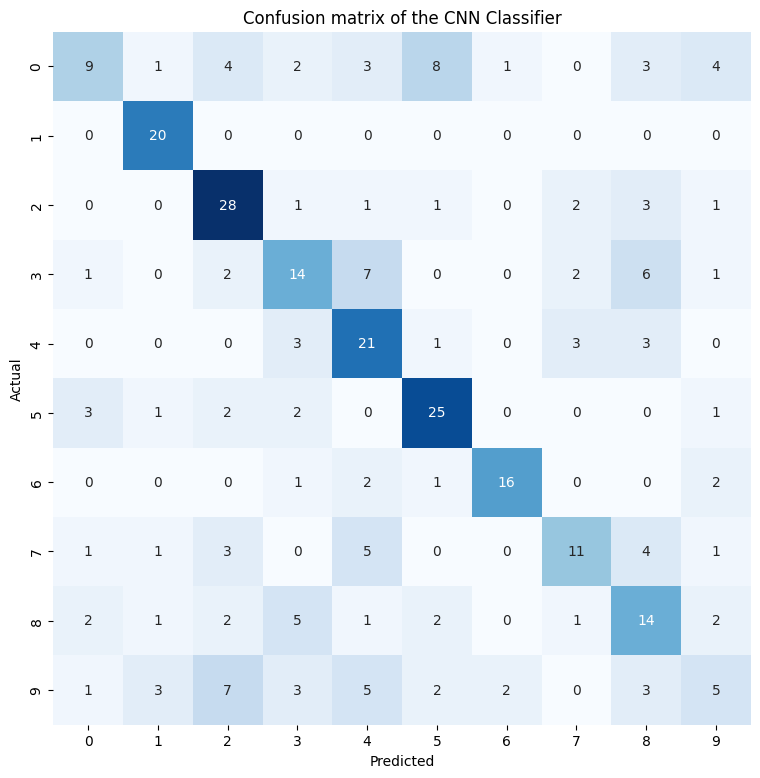

In [20]:

# """# VGG16 Training and Inference"""

bifurcation(models.vgg16)

import warnings
warnings.filterwarnings("ignore")

# model_vgg16, loss_vgg16, optim_vgg16 = selective_finetuning_single_layer(models.vgg16, 'classifier')
# model_vgg16, vgg16_train, vgg16_test, vgg16_pred, vgg16_true = model(train, test, 5, model_vgg16, loss_vgg16, optim_vgg16)

# Fine-tune multiple layers of VGG16
vgg_layers_to_finetune = ['features.24', 'features.25', 'classifier.0', 'classifier.3']

model_vgg16_multilayer, loss_vgg16, optim_vgg16 = selective_finetuning_multiple_layers(models.vgg16, vgg_layers_to_finetune)
if train is not None and test is not None:  # Check if train and test are not None
    model_vgg16_multilayer, vgg16_train, vgg16_test, vgg16_pred, vgg16_true = model(train, test, 5, model_vgg16_multilayer, loss_vgg16, optim_vgg16)
    
# model_vgg16_multilayer, vgg16_train, vgg16_test, vgg16_pred, vgg16_true = model(train, test, 5, model_vgg16_multilayer, loss_vgg16, optim_vgg16)


import seaborn as sns 
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(vgg16_true, vgg16_pred)
cf_matrix

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

#save the model
torch.save(model_vgg16_multilayer, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/vgg16_model.pth')


In [95]:
# saved_model_path = 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/vgg16_model.pth'
# model_vgg16 = torch.load(saved_model_path)
# def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
#     model.train()
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
#             inputs = inputs.to(device)
#             labels = labels.to(device)
            
#             optimizer.zero_grad()
            
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item() * inputs.size(0)
        
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
#     print('Training complete.')

# optim_vgg16 = torch.optim.Adam(filter(lambda p: p.requires_grad, model_vgg16.parameters()))
# crt = torch.nn.CrossEntropyLoss()
# train_model(model_vgg16, train, crt, optim_vgg16, num_epochs=5)

Epoch 1/5: 100%|██████████| 7/7 [00:42<00:00,  6.00s/it]


Epoch 1/5, Loss: 1.8907


Epoch 2/5: 100%|██████████| 7/7 [00:56<00:00,  8.08s/it]


Epoch 2/5, Loss: 1.7800


Epoch 3/5: 100%|██████████| 7/7 [00:42<00:00,  6.02s/it]


Epoch 3/5, Loss: 1.4664


Epoch 4/5: 100%|██████████| 7/7 [00:36<00:00,  5.24s/it]


Epoch 4/5, Loss: 1.4869


Epoch 5/5: 100%|██████████| 7/7 [00:55<00:00,  8.00s/it]

Epoch 5/5, Loss: 1.4377
Training complete.


The model predicted the audio to be blues


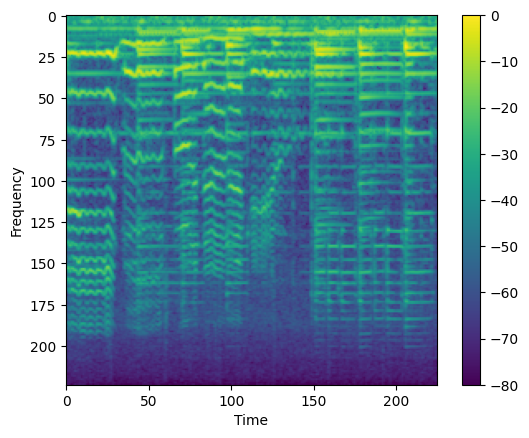

In [26]:
model_vgg16 = torch.load('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/vgg16_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original/blues/blues_00027.wav'
audio_file, y = lib.load(path_input)
hl = 512
hi = 224
wi = 224
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_vgg16.eval()
    output = model_vgg16(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')
    

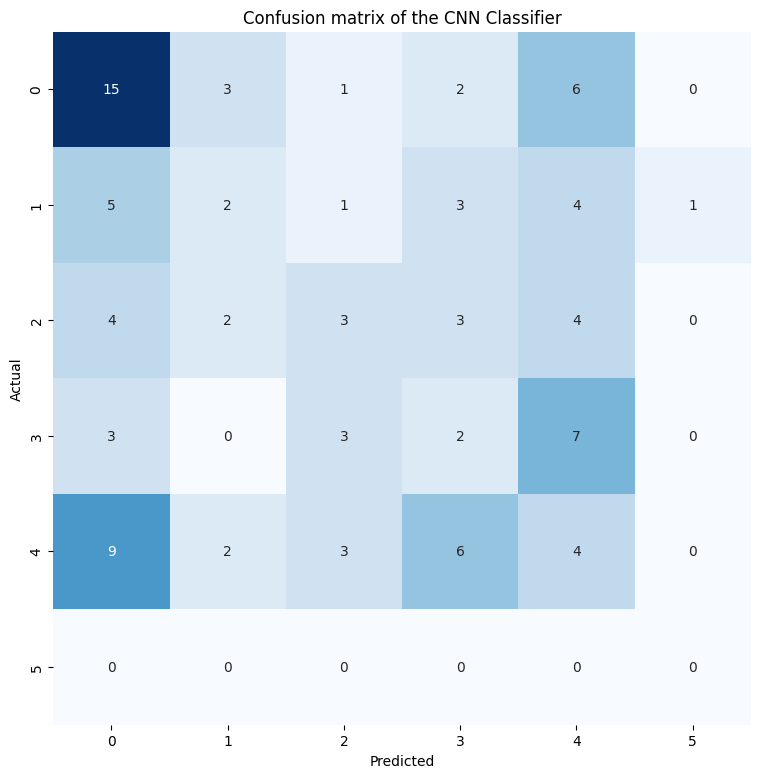

In [27]:

import seaborn as sns 
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(vgg16_true,vgg16_pred)
cf_matrix

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()


features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.block.0.0.weight
features.1.block.0.1.weight
features.1.block.0.1.bias
features.1.block.0.1.running_mean
features.1.block.0.1.running_var
features.1.block.0.1.num_batches_tracked
features.1.block.1.fc1.weight
features.1.block.1.fc1.bias
features.1.block.1.fc2.weight
features.1.block.1.fc2.bias
features.1.block.2.0.weight
features.1.block.2.1.weight
features.1.block.2.1.bias
features.1.block.2.1.running_mean
features.1.block.2.1.running_var
features.1.block.2.1.num_batches_tracked
features.2.block.0.0.weight
features.2.block.0.1.weight
features.2.block.0.1.bias
features.2.block.0.1.running_mean
features.2.block.0.1.running_var
features.2.block.0.1.num_batches_tracked
features.2.block.1.0.weight
features.2.block.1.1.weight
features.2.block.1.1.bias
features.2.block.1.1.running_mean
features.2.block.1.1.running_var
features.2.block.1.1.nu

100%|██████████| 11/11 [00:22<00:00,  2.04s/it]


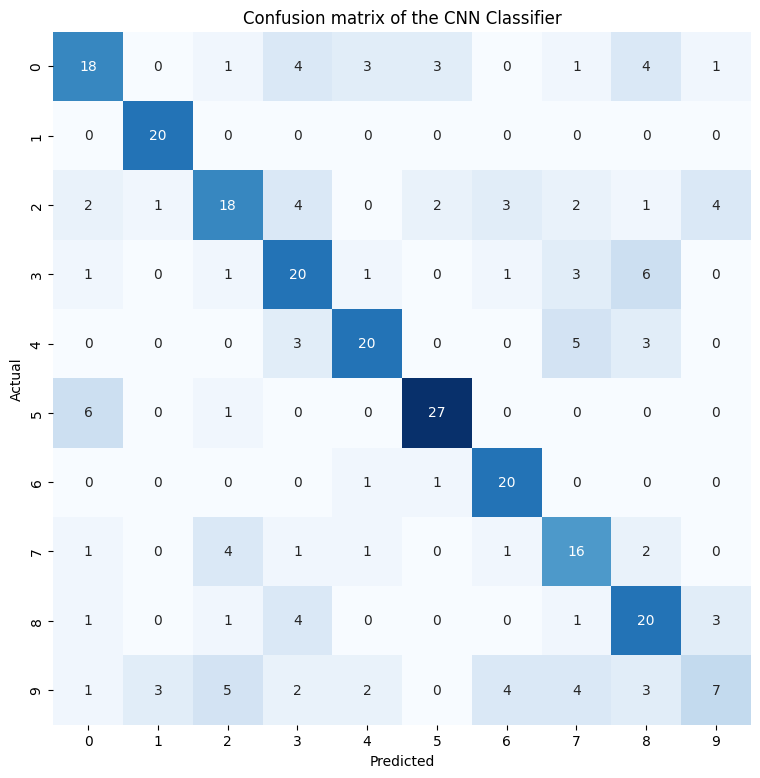

In [89]:

"""# Mobilenet-V3-Small Training and Inference"""

bifurcation(models.mobilenet_v3_small)

model_mobilenet_v3_small, loss_mobilenet_v3_small, optim_mobilenet_v3_small = selective_finetuning_multiple_layers(models.mobilenet_v3_small, 'classifier')

if train is not None and test is not None:  # Check if train and test are not None
    model_mobilenet_v3_small, mobilenet_v3_small_train, mobilenet_v3_small_test, mobilenet_v3_small_pred, mobilenet_v3_small_true = model(train, test, 5, model_mobilenet_v3_small, loss_mobilenet_v3_small, optim_mobilenet_v3_small)

# model_mobilenet_v3_small ,mobilenet_v3_small_train ,mobilenet_v3_small_test, mobilenet_v3_small_pred, mobilenet_v3_small_true = model(train,test,5,model_mobilenet_v3_small, loss_mobilenet_v3_small, optim_mobilenet_v3_small)

cf_matrix_mobilenet=confusion_matrix(mobilenet_v3_small_true,mobilenet_v3_small_pred)
cf_matrix_mobilenet

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_mobilenet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

torch.save(model_mobilenet_v3_small, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/mobilenet_v3_small_model.pth')


In [76]:
# model_mobilenet_v3_small = torch.load('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\mobilenet_v3_small_model.pth')
# optim_mobilenet_v3_small = torch.optim.Adam(filter(lambda p: p.requires_grad, model_mobilenet_v3_small.parameters()))
# train_model(model_mobilenet_v3_small, train, crt, optim_mobilenet_v3_small, num_epochs=5)

Epoch 1/5: 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Epoch 1/5, Loss: 0.8632


Epoch 2/5: 100%|██████████| 7/7 [00:26<00:00,  3.81s/it]


Epoch 2/5, Loss: 0.6698


Epoch 3/5: 100%|██████████| 7/7 [00:31<00:00,  4.51s/it]


Epoch 3/5, Loss: 0.5197


Epoch 4/5: 100%|██████████| 7/7 [00:14<00:00,  2.11s/it]


Epoch 4/5, Loss: 0.4866


Epoch 5/5: 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

Epoch 5/5, Loss: 0.3887
Training complete.


The model predicted the audio to be classical


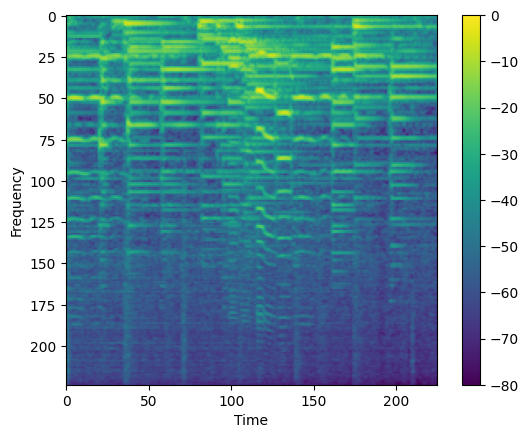

In [34]:
model_mobilenet_v3_small = torch.load('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\mobilenet_v3_small_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original\jazz\jazz_00016.wav'
audio_file, y = lib.load(path_input)
hl = 512
hi = 224
wi = 224
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_mobilenet_v3_small.eval()
    output = model_mobilenet_v3_small(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')
    # print(predicted)


features.conv0.weight
features.norm0.weight
features.norm0.bias
features.norm0.running_mean
features.norm0.running_var
features.norm0.num_batches_tracked
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.norm1.running_mean
features.denseblock1.denselayer1.norm1.running_var
features.denseblock1.denselayer1.norm1.num_batches_tracked
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.norm2.running_mean
features.denseblock1.denselayer1.norm2.running_var
features.denseblock1.denselayer1.norm2.num_batches_tracked
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.norm1.running_mean
features.denseblock1.denselayer2.norm1.running_var
features.denseblock1.denselayer2.norm1.num_batches_tracke

100%|██████████| 11/11 [00:40<00:00,  3.70s/it]


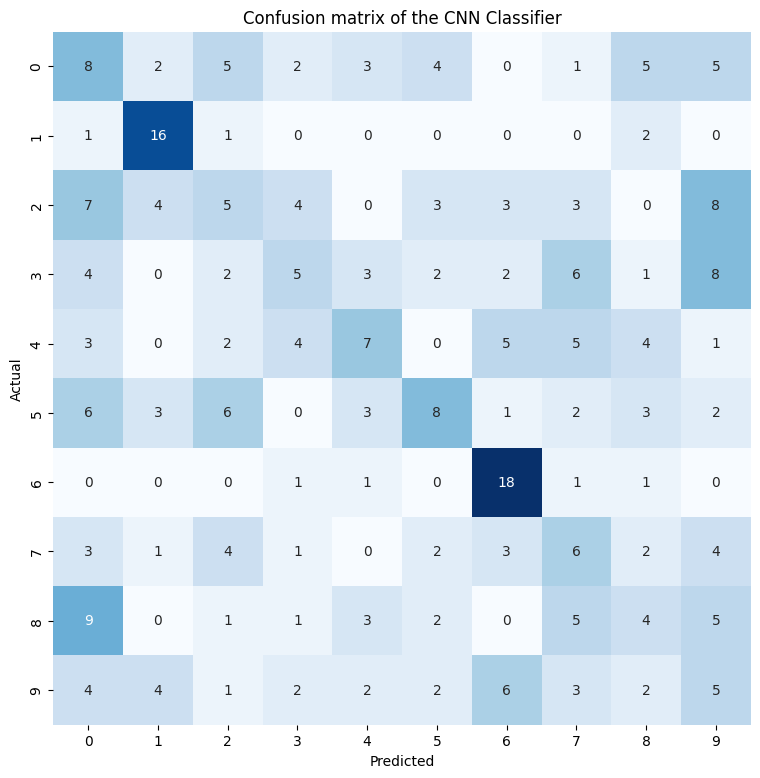

In [37]:

"""# Densenet-121 Training and Inference"""

bifurcation(models.densenet121)

# model_densenet121, loss_densenet121, optim_densenet121 = selective_finetuning_single_layer(models.densenet121, 'classifier')
# model_densenet121, densenet121_train, densenet121_test, densenet121_pred, densenet121_true = model(train, test, 5, model_densenet121, loss_densenet121, optim_densenet121)

# Fine-tune multiple layers of DenseNet-121
densenet_layers_to_finetune = ['classifier']

model_densenet121_multilayer, loss_densenet121, optim_densenet121 = selective_finetuning_multiple_layers(models.densenet121, densenet_layers_to_finetune)
if train is not None and test is not None:  # Check if train and test are not None
    model_densenet121_multilayer, densenet121_train, densenet121_test, densenet121_pred, densenet121_true = model(train, test, 5, model_densenet121_multilayer, loss_densenet121, optim_densenet121)

# model_densenet121_multilayer, densenet121_train, densenet121_test, densenet121_pred, densenet121_true = model(train, test, 5, model_densenet121_multilayer, loss_densenet121, optim_densenet121)

cf_matrix_densenet = confusion_matrix(densenet121_true, densenet121_pred)
cf_matrix_densenet

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_densenet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

torch.save(model_densenet121_multilayer, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/densenet121_model.pth')


The model predicted the audio to be Sad


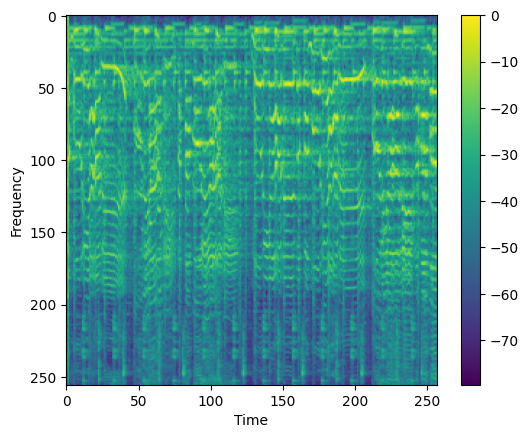

In [159]:
model_densenet121 = torch.load('D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\densenet121_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original\metal\metal_00009'
audio_file, y = lib.load(path_input)
hl = 1024
hi = 256
wi = 256
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_densenet121.eval()
    output = model_densenet121(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.0.1.running_mean
features.0.1.running_var
features.0.1.num_batches_tracked
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.0.1.running_mean
features.1.0.block.0.1.running_var
features.1.0.block.0.1.num_batches_tracked
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.0.block.2.1.running_mean
features.1.0.block.2.1.running_var
features.1.0.block.2.1.num_batches_tracked
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.0.1.running_mean
features.2.0.block.0.1.running_var
features.2.0.block.0.1.num_batches_tracked
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.1.1.running_mean
feat

100%|██████████| 11/11 [00:10<00:00,  1.04it/s]


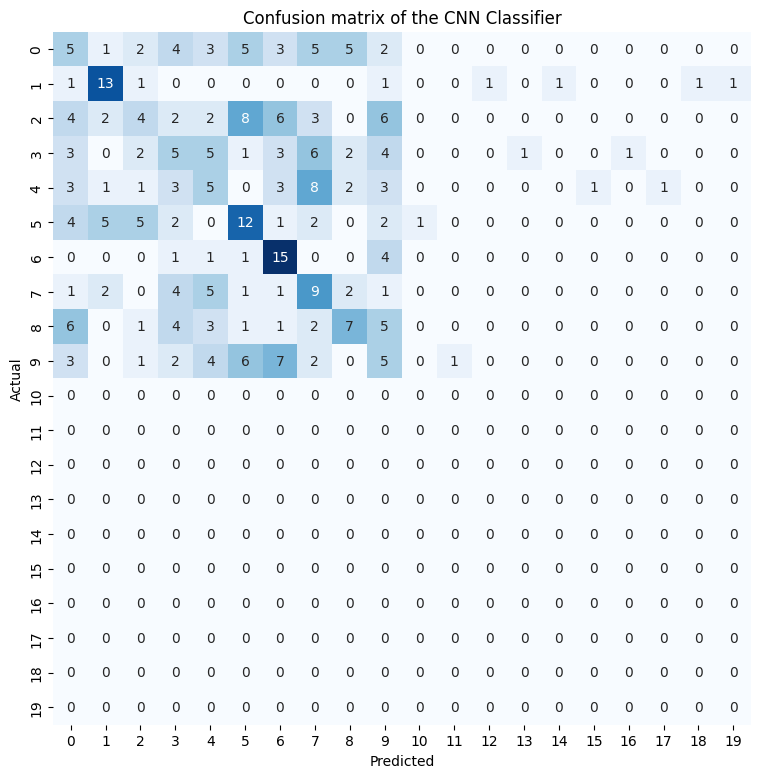

In [36]:

"""# Efficientnet-B0 Training and Inference"""

bifurcation(models.efficientnet.efficientnet_b0)

model_efficientnet_b0, loss_efficientnet_b0, optim_efficientnet_b0 = selective_finetuning_multiple_layers(models.efficientnet_b0, 'classifier')
if train is not None and test is not None:  # Check if train and test are not None
    model_efficientnet_b0, efficientnet_b0_train, efficientnet_b0_test, efficientnet_b0_pred, efficientnet_b0_true = model(train, test, 5, model_efficientnet_b0, loss_efficientnet_b0, optim_efficientnet_b0)

# model_efficientnet_b0, efficientnet_b0_train, efficientnet_b0_test, efficientnet_b0_pred, efficientnet_b0_true = model(train, test, 5, model_efficientnet_b0, loss_efficientnet_b0, optim_efficientnet_b0)

cf_matrix_efficientnet_b0 = confusion_matrix(efficientnet_b0_true, efficientnet_b0_pred)
cf_matrix_efficientnet_b0

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_efficientnet_b0, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

torch.save(model_efficientnet_b0, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/efficientnet_b0_model.pth')

The model predicted the audio to be metal


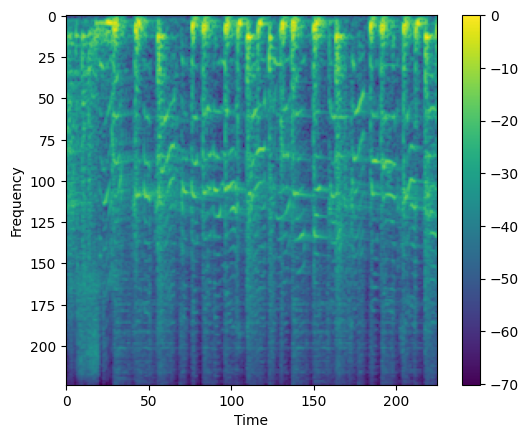

In [40]:

model_efficientnet_b0 = torch.load('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/efficientnet_b0_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original\hiphop\hiphop_00010.wav'
audio_file, y = lib.load(path_input)
hl = 512
hi = 224
wi = 224
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_efficientnet_b0.eval()
    output = model_efficientnet_b0(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


100%|██████████| 11/11 [00:36<00:00,  3.32s/it]


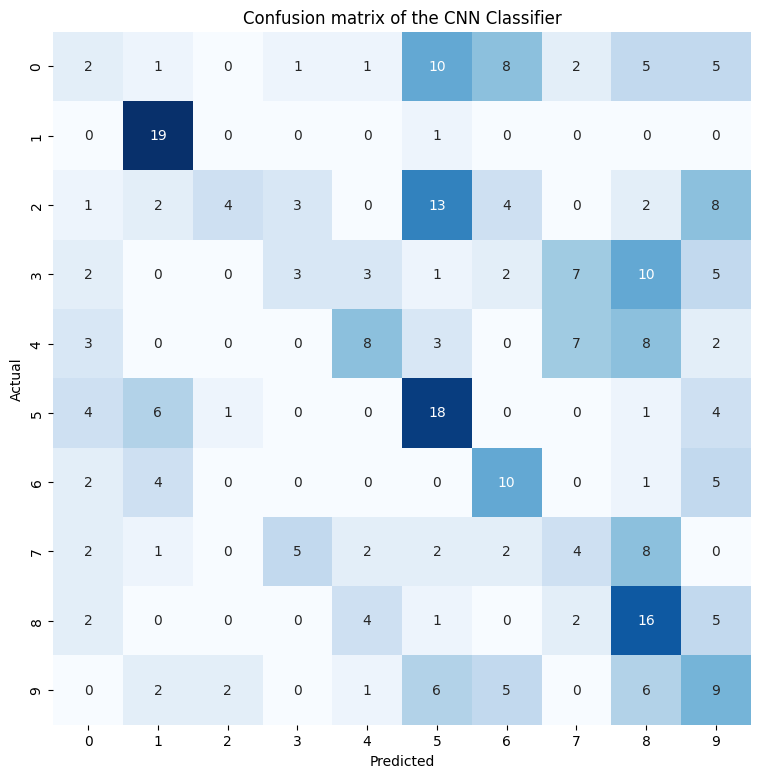

In [41]:

"""# Alexnet Training and Inference"""

bifurcation(models.alexnet)

model_alexnet, loss_alexnet, optim_alexnet = selective_finetuning_multiple_layers(models.alexnet, 'classifier')
if train is not None and test is not None:  # Check if train and test are not None
    model_alexnet, alexnet_train, alexnet_test, alexnet_pred, alexnet_true = model(train, test, 5, model_alexnet, loss_alexnet, optim_alexnet)

# model_alexnet, alexnet_train, alexnet_test, alexnet_pred, alexnet_true = model(train, test, 5, model_alexnet, loss_alexnet, optim_alexnet)

cf_matrix_alexnet = confusion_matrix(alexnet_true, alexnet_pred)
cf_matrix_alexnet

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_alexnet, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()

torch.save(model_alexnet, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/alexnet_model.pth')

The model predicted the audio to be jazz


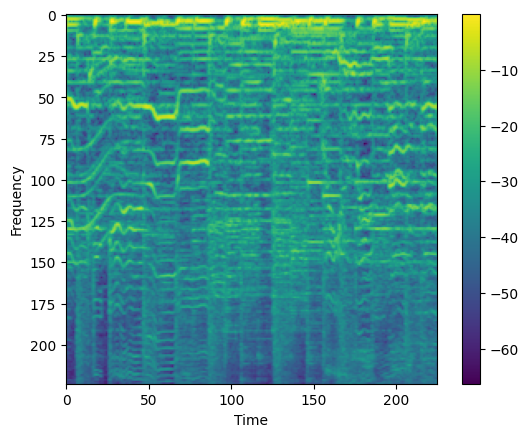

In [42]:

model_alexnet = torch.load('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/alexnet_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\genres_original\country\country_00005.wav'
audio_file, y = lib.load(path_input)
hl = 512
hi = 224
wi = 224
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_alexnet.eval()
    output = model_alexnet(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn1.running_mean
layer2.0.bn1.running_var
layer2.0.bn1.num_batches_tracked
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.bn2.running_mean
layer2.0.bn2.running_var
layer2.0.bn2.num_batches_tracked
layer2.0.downsample.0.weight
layer2.0.downsamp

100%|██████████| 11/11 [00:53<00:00,  4.91s/it]


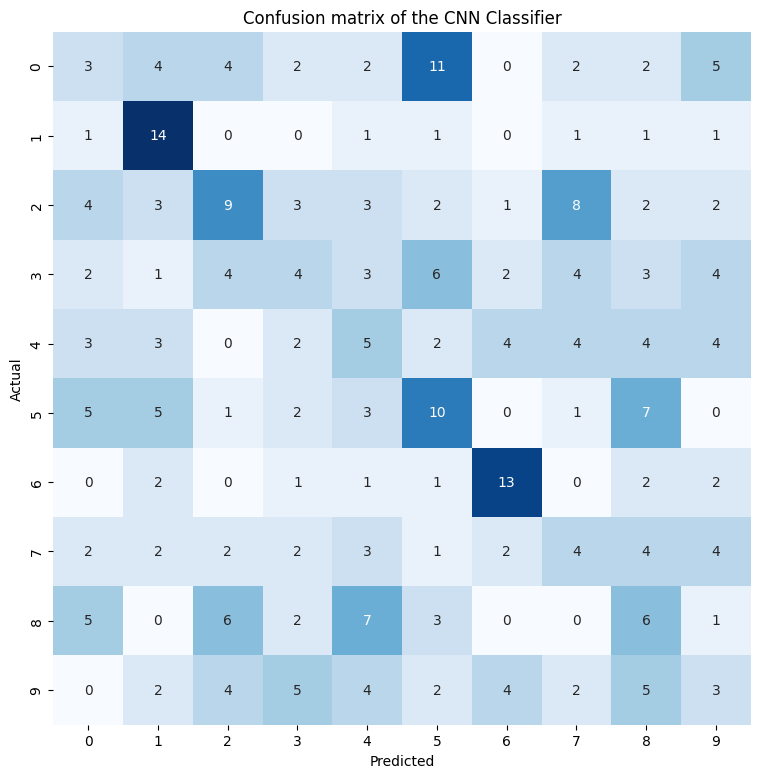

In [43]:

"""# ResNet18 Training and Inference"""

bifurcation(models.resnet18)

model_resnet18, loss_resnet18, optim_resnet18 = selective_finetuning_multiple_layers(models.resnet18, 'fc')
if train is not None and test is not None:  # Check if train and test are not None
    model_resnet18, resnet18_train, resnet18_test, resnet18_pred, resnet18_true = model(train, test, 5, model_resnet18, loss_resnet18, optim_resnet18)

# model_resnet18, resnet18_train, resnet18_test, resnet18_pred, resnet18_true = model(train, test, 5, model_resnet18, loss_resnet18, optim_resnet18)

cf_matrix_resnet18 = confusion_matrix(resnet18_true, resnet18_pred)
cf_matrix_resnet18

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix_resnet18, cbar=False, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()
    
torch.save(model_resnet18, 'D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/resnet18_model.pth')


The model predicted the audio to be country


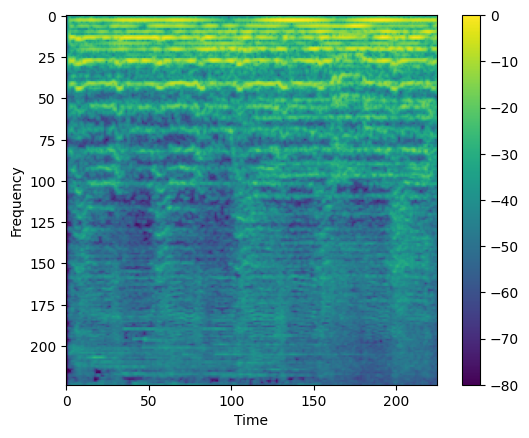

In [49]:

model_resnet18 = torch.load('D:/College/Semester 6/ML/Lab/Project-MoodDetectionUsingSongs/resnet18_model.pth')
class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
path_input = 'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs\MER500\Devotional\Devotional\Devotional_108.wav'
audio_file, y = lib.load(path_input)
hl = 512
hi = 224
wi = 224
audio_window = audio_file[0:wi*hl]
spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
plot = lib.power_to_db(spectrogram, ref=np.max)
plt.imshow(plot)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0, 0, 0], [1, 1, 1])])(final_plot)[None].to(device)
with torch.no_grad():
    model_resnet18.eval()
    output = model_resnet18(model_input)
    _, predicted = torch.max(output, 1)
    print(f'The model predicted the audio to be {class_names[predicted]}')

In [80]:
import torch
import librosa as lib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_mood(audio_file_path, model_passed, device='cpu'):

    class_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

    # Load audio file
    audio_file, y = lib.load(audio_file_path)
    
    # Constants
    hl = 512
    hi = 224
    wi = 224
    
    # Process audio
    audio_window = audio_file[0:wi*hl]
    spectrogram = lib.feature.melspectrogram(y = audio_window, sr = y, n_mels = hi, fmax = 9000, hop_length = hl)
    plot = lib.power_to_db(spectrogram, ref=np.max)
    
    # Resize plot
    final_plot = cv2.resize(cv2.cvtColor(plot, cv2.COLOR_GRAY2RGB), (224, 224))
    
    # Prepare model input
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    model_input = transform(final_plot).unsqueeze(0).to(device)
    
    # Ensure model is on the same device as the input
    model_passed = model_passed.to(device)
    
    with torch.no_grad():
        model_passed.eval()
        output = model_passed(model_input)
        _, predicted = torch.max(output, 1)
        return "none" if predicted.item() < -10 or predicted.item() > 9 else class_names[predicted.item()]



In [88]:
import os
import random

root_dir = 'D:\\College\\Semester 6\\ML\\Lab\\Project-MoodDetectionUsingSongs\\genres_original'

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

selected_paths = []

for genre in genres:
    genre_dir = os.path.join(root_dir, genre)
    files = os.listdir(genre_dir)
    random.shuffle(files)
    selected_files = files[:40]
    for file in selected_files:
        file_path = os.path.join(genre_dir, file)
        selected_paths.append((file_path, genre))

random.shuffle(selected_paths)

final_selection = selected_paths[:400]

# Define model paths
model_paths = [
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/alexnet_model.pth',
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/densenet121_model.pth',
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/efficientnet_b0_model.pth',
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/mobilenet_v3_small_model.pth',
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/resnet18_model.pth',
    'D:\College\Semester 6\ML\Lab\Project-MoodDetectionUsingSongs/vgg16_model.pth'
]

for path in model_paths:
    model_path = torch.load(path, map_location=torch.device('cpu'))
    filename = path.split('\\')[-1]
    success = 0
    for audio_path, genre in final_selection:
        predicted_mood = predict_mood(audio_path, model_path)
        if predicted_mood == genre:  # corrected typo here
            success += 1
    
    print(f"{filename} accuracy is: {success/4}")  # corrected typo here as well
    

Project-MoodDetectionUsingSongs/alexnet_model.pth accuracy is: 37.5
Project-MoodDetectionUsingSongs/densenet121_model.pth accuracy is: 7.5


KeyboardInterrupt: 

In [ ]:

"""# Loss v/s Epochs and Accuracy v/s Epochs Curves"""

resnet18_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in resnet18_train]
vgg16_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in vgg16_train]
densenet121_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in densenet121_train]
mobilenet_v3_small_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in mobilenet_v3_small_train]
efficientnet_b0_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in efficientnet_b0_train]
alexnet_train_cpu = [(item[0].cpu().numpy(), item[1]) for item in alexnet_train]

plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_train[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_train[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_test[i][1] for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_test[i][1] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_train[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_train[i][2].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epochs for Training")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,6)],[resnet18_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[vgg16_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[densenet121_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[mobilenet_v3_small_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[efficientnet_b0_test[i][2].cpu().numpy() for i in range(0,5)])
plt.plot([j for j in range(1,6)],[alexnet_test[i][2].cpu().numpy() for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epochs for Testing")
plt.legend(["ResNet18","VGG16","DenseNet121","Mobilenet_v3_small","Efficientnet_b0","Alexnet"])
plt.show()

"""#Wandb Saves"""

import wandb

# torch.save(model_vgg16, '/content/drive/MyDrive/DL_Project_2/model_vgg16.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('VGG16', type='VGG16')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_vgg16.pth')
# run.log_artifact(artifact)
# run.join()

# torch.save(model_alexnet, '/content/drive/MyDrive/DL_Project_2/model_alexnet.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('alexnet', type='alexnet')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_alexnet.pth')
# run.log_artifact(artifact)
# run.join()

# torch.save(model_efficientnet_b0, '/content/drive/MyDrive/DL_Project_2/model_efficientnet_b0.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('efficientnet_b0', type='efficientnet_b0')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_efficientnet_b0.pth')
# run.log_artifact(artifact)
# run.join()

# torch.save(model_mobilenet_v3_small, '/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('mobilenet_v3_small', type='mobilenet_v3_small')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth')
# run.log_artifact(artifact)
# run.join()

# torch.save(model_resnet18, '/content/drive/MyDrive/DL_Project_2/model_resnet18.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('resnet18', type='resnet18')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_resnet18.pth')
# run.log_artifact(artifact)
# run.join()

# torch.save(model_densenet121, '/content/drive/MyDrive/DL_Project_2/model_densenet121.pth')
# run = wandb.init(project='DL_Project_2')
# artifact = wandb.Artifact('densenet121', type='densenet121')
# artifact.add_file('/content/drive/MyDrive/DL_Project_2/model_densenet121.pth')
# run.log_artifact(artifact)
# run.join()

!pip install wandb

# """# End-To-End Pipeline"""

# path = input("Enter the File-Path for 10-Seconds Hindi-Music Based Emotion Classification :- ")
# input_audio , y = lib.load(path)
# hl = 512 # number of samples per time-step in spectrogram
# hi = 224 # Height of image
# wi = 224 # Width of image
# audio_window = input_audio[0:wi*hl]
# spectrogram = lib.feature.melspectrogram(y=audio_window, sr=y, n_mels=hi, fmax=8000, hop_length=hl)
# plot = lib.power_to_db(spectrogram, ref=np.max)
# plt.imshow(plot)
# final_plot = cv2.resize(cv2.cvtColor(plot,cv2.COLOR_GRAY2RGB),(224,224))

# print(" ")
# print("Pre-Trained Models List\n")
# print("1. Alexnet\n")
# print("2. EfficientNet-B0\n")
# print("3. ResNet18\n")
# print("4. VGG16\n")
# print("5. MobileNet_V3_Small\n")
# print("6. DenseNet121\n\n")
# model_choice = int(input("Enter the Choice of Model :- \n"))
# if model_choice==1:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_alexnet.pth', map_location='cuda:0')
# if model_choice==2:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_eddicientnet_b0.pth', map_location='cuda:0')
# if model_choice==3:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_resnet18.pth', map_location='cuda:0')
# if model_choice==4:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_vgg16.pth', map_location='cuda:0')
# if model_choice==5:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_mobilenet_v3_small.pth', map_location='cuda:0')
# if model_choice==6:
#   model = torch.load('/content/drive/MyDrive/DL_Project_2/model_densenet121.pth', map_location='cuda:0')

# class_map = {0:'Sad',1:'Romantic',2:'Devotional',3:'Party',4:'Happy'}
# model_input = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,0,0), (1,1,1))])(final_plot)[None]
# with torch.no_grad():
#   output = model(model_input.cuda())
#   class_predict = output.data.max(1, keepdim=True)[1]
#   print("\nPredicted Emotion -->"+class_map[class_predict.cpu().numpy()[0][0]])

